In [1]:
import pandas as pd

from modules.model import CoxTimeVaryingEstimator, PredictionsAggregator
from modules.metrics_TV import get_ci_and_ibs
from modules.constants import TRAIN_GRID, TEST_GRID, SCHEMA, TIMES

import time
import numpy as np
import pickle
import copy

In [3]:
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [367]:
df_train_max_samples = pd.read_csv(f'Preprocessed/10_train_preprocessed.csv')

In [368]:
cox = load_model(f"models/182_model.pkl")

In [394]:
import seaborn as sns
from metrics import ibs_remain
from lifelines.utils import concordance_index
import pandas as pd
import numpy as np

def prepare_data_for_test(df, id_col='id', time_col='time', event_col='event', mode = 'independent'):
    '''
    На вход принимает датасет вида id_col, time_col, event_col, признаки
    На выходе датафрейм, events, durations
    У датафрейма отсечены самые последние наблюдения соответствующие каждому диску
    '''
    durations = df.groupby(id_col)[time_col].transform('max') - df[time_col]
    events = df.groupby(id_col)[event_col].transform('max')[durations != 0]
    result_df = df.loc[durations != 0, :]
    durations = durations[durations != 0]
    if mode=='agg':
        last_observ = result_df[time_col] == result_df.groupby(id_col)[time_col].transform('max')
        events = events[last_observ]
        durations = durations[last_observ]
    return result_df, events.astype('bool'), durations

def get_ci_and_ibs(model, df_test, times, mode='independent'):
    '''
    mode in {independent, agg}
    Возвращает CI и IBS
    '''

    X_test, test_events, test_durations = prepare_data_for_test(df_test, id_col=model.id_col, time_col=model.time_col, event_col = model.event_col, mode = mode)
    survival_test = pd.DataFrame()
    survival_test['event'] = test_events
    survival_test['duration'] = test_durations

    X_pred = model.predict(X_test, times)
    lifetime_pred = model.get_expected_time_by_predictions(X_pred, times)
    
    ci = concordance_index(test_durations, lifetime_pred, test_events)
    survival_estim = X_pred.drop([model.id_col, model.time_col], axis='columns')
#     survival_estim = survival_estim**3
    
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
    for i in range(7):
        survival_estim.iloc[i].plot(ax=axes[0], label=f"{survival_test.iloc[i]['duration']}, {survival_test.iloc[i]['event']}")
    
    sns.kdeplot(data=survival_test, x="duration", hue="event", ax=axes[1])
    
    ibs = ibs_remain(None, 
        survival_test.to_records(index=False),  
        survival_estim, times)
    
    survival_test["ibs"] = ibs_remain(None, 
        survival_test.to_records(index=False),  
        survival_estim, times, axis=0)
    
    print(survival_test['event'].value_counts())
    print(f"CI: {ci}, IBS: {ibs}")
    sns.scatterplot(data=survival_test, x="duration", y="ibs", hue="event", ax=axes[2])
    plt.show()
    return ci, ibs

In [395]:
df_train_1 = pd.read_csv(f'Preprocessed/10_train_preprocessed.csv')

df_train_1 = df_train_1.sort_values(by=['id', 'time'], ascending=False)
df_train_1 = pd.concat([df_train_1.groupby('id').tail(3), 
                        df_train_1.groupby('id').head(1)])
df_train_1 = df_train_1.drop_duplicates().sort_values(by=['id', 'time'], ascending=True).reset_index()

event
False    15042
True      2314
Name: count, dtype: int64
CI: 0.789553382483511, IBS: 0.18648497245632584


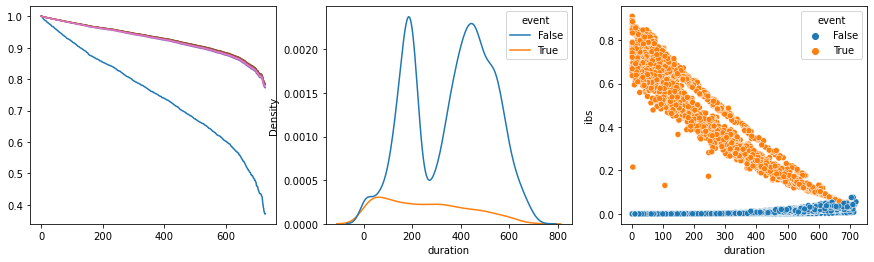

event
False    15042
True      2314
Name: count, dtype: int64
CI: 0.7427248765495401, IBS: 0.18130822474282496


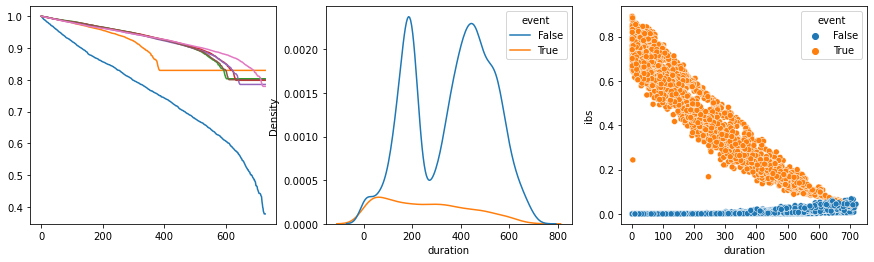

event
False    15042
True      2314
Name: count, dtype: int64
CI: 0.7619132124110362, IBS: 0.1832389376117425


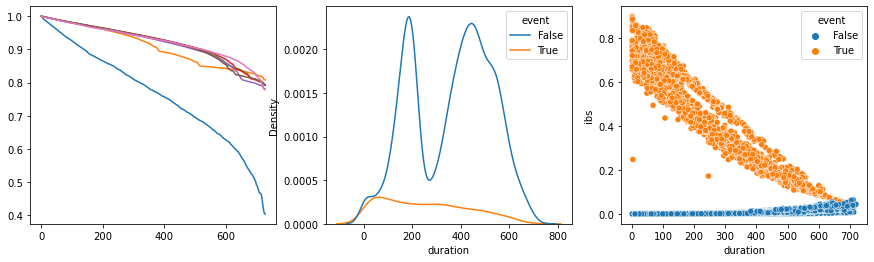

(0.7619132124110362, 0.1832389376117425)

In [396]:
get_ci_and_ibs(PredictionsAggregator(cox, 'last'), df_test=df_train_1, times=TIMES, mode='agg')
get_ci_and_ibs(PredictionsAggregator(cox, 'first'), df_test=df_train_1, times=TIMES, mode='agg')
get_ci_and_ibs(PredictionsAggregator(cox, 'prob_dist'), df_test=df_train_1, times=TIMES, mode='agg')

# get_ci_and_ibs(cox, df_test=df_train_1, times=TIMES, mode='independent')

In [ ]:
# ascending=True
CI: 0.789553382483511, IBS: 0.18648497245632584
CI: 0.7427248765495401, IBS: 0.18130822474282496
CI: 0.7619132124110362, IBS: 0.1832389376117425
        
# ascending=False
CI: 0.34121878665724786, IBS: 0.2461540980930679
CI: 0.33294828252037556, IBS: 0.2387960103907716
CI: 0.33551252193478215, IBS: 0.24226441064517396